## CO2 flux analysis

### Methods:

1. Load geometries and inversion CO2 data and preprocess as necessary.
2. Select the ROI (region of interest), initially using a small test region.
3. Create a grouping coordinate that divides growing and non-growing seasons.   
    - Initially this can be done manually. Later consider fitting a harmonic to divide seasons.  
4. For each year and season, calculate the CO2 flux sum.
5. For each year, get the difference between growing and non-growing season.
    - This is the CO2 flux amplitude that can then be related to atmospheric CO2 and driving variables.  

### Details

#### Geometries 

Geometry objects are used to mask or filter the data, e.g. continents, above 50N, ecoregions, test region.

#### Loading raster data

Check units. Could be that they are per pixel and not per area (Carboscope inversion seems to be so).

#### Applying same crs to all data

Using the common WGS84: EPSG 4326. This should be set to all rasters used. If the crs was WGS84 but the property was not set, then use:  
`mydata.rio.write_crs("epsg:4326", inplace=True)`  

Else, change the crs with   
`mydata.rio.reproject("EPSG:4326")`  

When adding more datasets, these can be adjusted to the first using:  
`mydata2 = mydata2.rio.reproject_match(mydata)`  

#### Set a missing data value

Set a missing data value to be same across all data, e.g. -9999.   

`mydata.rio.set_nodata(-9999, inplace=True)` # will set the nadata attrribute without modifying the data
`mydata.rio.write_nodata(-9999, inplace=True)` # will write to the array (I guess replacing the existing missing data value?) Need to test.  

Note that the reproject_match method from above will modify the nodata value of mydata2 to match that of mydata.  

Use the following to mask the missing data:  
```
nodata = raster.rio.nodata
raster = raster.where(raster != nodata)
raster.rio.write_nodata(nodata, encoded=True, inplace=True)
```

In [1]:
# Get all required packages
# import ee
# from osgeo import gdal
# from pyproj import CRS
# import geemap as gm

import rioxarray as rio
import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [2]:
# Setup for Earth Engine
# ee.Authenticate()
# ee.Initialize()

In [3]:
# Some common setting:
nodata = -9999.0
epsg_crs = 4326

#### Load geometries data

In [4]:
import geopandas as gpd
from shapely.geometry import box

conts_file = '/Users/moyanofe/Work/Augsburg/Research/LandCover/data/continents.geojson'
north50_file = '/Users/moyanofe/Work/Augsburg/Research/LandCover/data/north50.geojson'
north30_file = '/Users/moyanofe/Work/Augsburg/Research/LandCover/data/north30.geojson'
north0_file = '/Users/moyanofe/Work/Augsburg/Research/LandCover/data/north0.geojson'
testrect_file = '/Users/moyanofe/Work/Augsburg/Research/LandCover/data/testrect.geojson'

conts = gpd.read_file(conts_file)
north50 = gpd.read_file(north50_file)
north30 = gpd.read_file(north30_file)
north0 = gpd.read_file(north0_file)
testrect = gpd.read_file(testrect_file)
conts_north50 = conts.clip(north50)
testarea = conts.clip(testrect)
# print(conts.crs)
# print(north50.crs)
# conts.plot()
# north50.plot()
# testarea.plot()
# conts_north50.plot()

# Set here the region for the analysis
roi = conts

/Users/moyanofe/miniconda3/envs/landcover/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/Users/moyanofe/miniconda3/envs/landcover/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


### Load CO2 from inversion and do some processing

In [5]:
# Open data with Gdal and get the CRS information
# file_path = '/Users/moyanofe/BigData/GeoSpatial/Carboscope/Inversions/s85oc_v2022_daily.tiff'
file_path = '/Users/moyanofe/BigData/GeoSpatial/Carboscope/Inversions/s85oc_v2022_daily.nc'

# All three file reading methods read in the attributes differently.
# co2InvRaw = rio.open_rasterio(file_path)
# co2InvRaw = xr.open_dataset(file_path, engine="rasterio", variable='co2flux_land')
co2InvRaw_List = rio.open_rasterio(file_path, variable='co2flux_land')
co2InvRaw = co2InvRaw_List['co2flux_land']  # Extracting the dataarray from the list
co2InvRaw = co2InvRaw.rename({'mtime': 'time'})  # Rename the time dimension and coordinate to something standard.
co2InvRaw = co2InvRaw.rename({'x': 'longitude'})  # Rename the time dimension and coordinate to something standard.
co2InvRaw = co2InvRaw.rename({'y': 'latitude'})  # Rename the time dimension and coordinate to something standard.
co2InvRaw.attrs['units'] = 'PgC/yr'  # For some reason the units is a tuple of repeating values. Replacing with single value.
co2InvRaw.rio.write_crs(4326, inplace=True)  # Set the crs (this is creating the spatial_ref coordinate)

# Setting nodata
# co2InvRaw.data = np.where(co2InvRaw.data == co2InvRaw.rio.nodata, nodata, co2InvRaw.data) # If there are any nodata values, replace them with the new definition
co2InvRaw = co2InvRaw.rio.write_nodata(nodata)  # Set the new nodata value
co2InvRaw = co2InvRaw.rio.write_nodata(co2InvRaw.rio.nodata, encoded=True, inplace=True)  # nodata value is enconded (not sure what this is or if necessary)

In [6]:
# Read in the area per pixel. The file contains 2 layers, of which the first seems to be land area.
pixarea_List = rio.open_rasterio(file_path, variable='area')
pixarea = pixarea_List['area']
pixarea = pixarea.rename({'x': 'longitude'})  # Rename the time dimension and coordinate to something standard.
pixarea = pixarea.rename({'y': 'latitude'})  # Rename the time dimension and coordinate to something standard.
landarea = pixarea[0]
landarea.attrs['units'] = 'm2'
landarea.coords.__delitem__('rt')

# Convert the co2 flux units: pixel to sqm, then to ha; and petagram to tons, so PgC y-1 -> tC ha-2 y-1
co2Inv = co2InvRaw / landarea * 10000 * 10**9 # to sqm, to ha, to tons.

In [7]:
# Add info
co2Inv.attrs['units'] = 'tC/ha/y'
co2Inv.attrs['long_name'] = 'Land-atmosphere co2 flux'

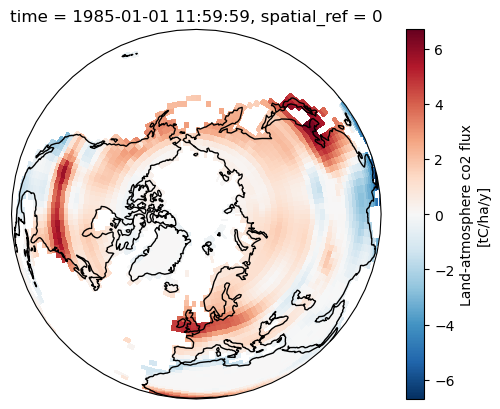

In [8]:
# Check data
# print(co2Inv.attrs)
p = co2Inv.isel(time=0).plot(
    subplot_kws=dict(projection=ccrs.Orthographic(0, 90), facecolor="white"),
    transform=ccrs.PlateCarree(),
)
p.axes.set_global()
p.axes.coastlines()
# co2Inv = co2Inv.reindex({'lat':co2Inv.lat[::-1]})  # Reindexing not necessary. Maybe depends on the open file function.

In [9]:
# Cut the data to the region of interest
# co2InvT = co2Inv.rio.clip(testarea.geometry, testarea.crs, all_touched=True)
co2InvT = co2Inv.rio.clip(roi.geometry, north30.crs, all_touched=True)

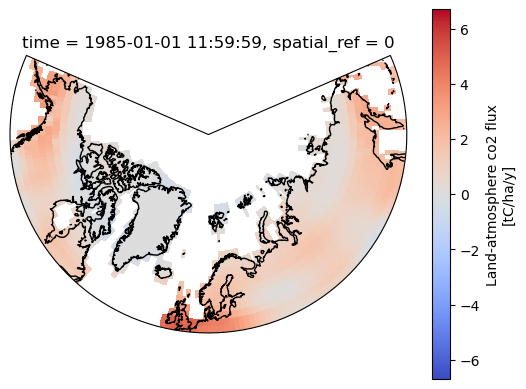

In [10]:
# print(co2IT)
p = co2InvT.isel(time=0).plot(
    subplot_kws=dict(
        projection=ccrs.LambertConformal(  # projection=ccrs.Orthographic(0, 90)
            central_longitude=10.0,
            central_latitude=39.0,
            false_easting=0.0,
            false_northing=0.0,
            standard_parallels=(33, 45),
            globe=None, cutoff=50),
        facecolor="white"),
    transform=ccrs.PlateCarree(),
    cmap='coolwarm'
)
p.axes.set_global()
p.axes.coastlines()

In [11]:
months = co2InvT.time.dt.month.data
# season = np.where(np.logical_or(months < 4, months > 9), 0, 1)
season = np.where((months < 4) | (months > 9), 0, 1)
groups = co2InvT.time.dt.year.data + (season/10)
co2InvT['groups'] = ('time', groups)
# co2IT['season'] = ('time', season)
# groups[0:365]

In [12]:
# co2InvS = co2Inv.groupby(['time.year', 'season']).mean()  # grouping by two variables is not supported in xarray!
co2InvTG = co2InvT.groupby('groups').mean()

In [13]:
# Check the output
print(co2InvTG[0:,0,0])
print(co2InvTG.coords['groups'])

<xarray.DataArray (groups: 74)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])
Coordinates:
    longitude    float64 -178.8
    latitude     float64 83.0
    spatial_ref  int64 0
  * groups       (groups) float64 1.985e+03 1.985e+03 ... 2.021e+03 2.021e+03
<xarray.DataArray 'groups' (groups: 74)>
array([1985. , 1985.1, 1986. , 1986.1, 1987. , 1987.1, 1988. , 1988.1, 1989. ,
       1989.1, 1990. , 1990.1, 1991. , 1991.1, 1992. , 1992.1, 1993. , 1993.1,
       1994. , 1994.1, 1995. , 1995.1, 1996. , 1996.1, 1997. , 1997.1, 1998. ,
       1998.1, 1999. , 1999.1, 2000. , 2000.1, 2001. , 2001.1, 2002. , 2002.1,
       2003. , 2003.

In [14]:
# Add again the coordinate representing years
years = np.round(co2InvTG.coords['groups'].data)
co2InvTG['year'] = ('groups', years)

# Check values
# print(co2InvTG.coords['year'])
# co2InvTG.where(co2InvTG.year==1985, drop=True)

# Calculate the difference between the seasonal averages
def diff(x):
    return(x[0] - x[1])
co2InvTD = co2InvTG.groupby('year').map(diff)

In [15]:
# Add some information


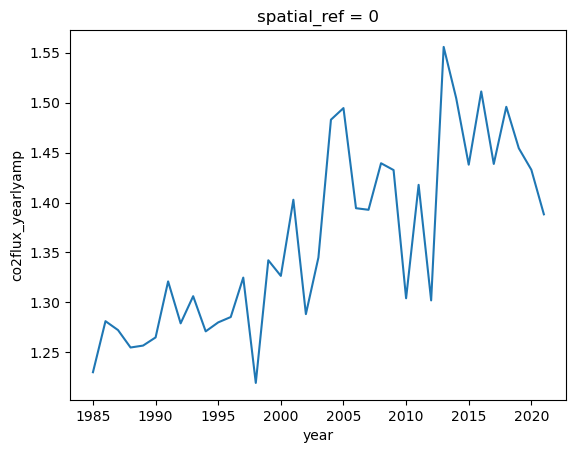

In [16]:
# Just renaming the xarray data array
co2InvTD = co2InvTD.rename('co2flux_yearlyamp')

# This line calculates the mean across the given dimensions, so for the entire region in this case.
regDiffMean = co2InvTD.mean(['longitude','latitude'])

# The data is now a one dimensional time series, so it is plotted as a line graph.
regDiffMean.plot()

In [17]:
# Calculate trends
from xarrayutils.utils import linear_trend
fluxamp_trends = linear_trend(co2InvTD, 'year')
fluxamp_trends.slope.attrs['units'] = 'tC/ha/y'
fluxamp_trends.slope.attrs['long_name'] = 'Trend in seasonal CO2 flux amplitude'

/Users/moyanofe/miniconda3/envs/landcover/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/moyanofe/miniconda3/envs/landcover/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


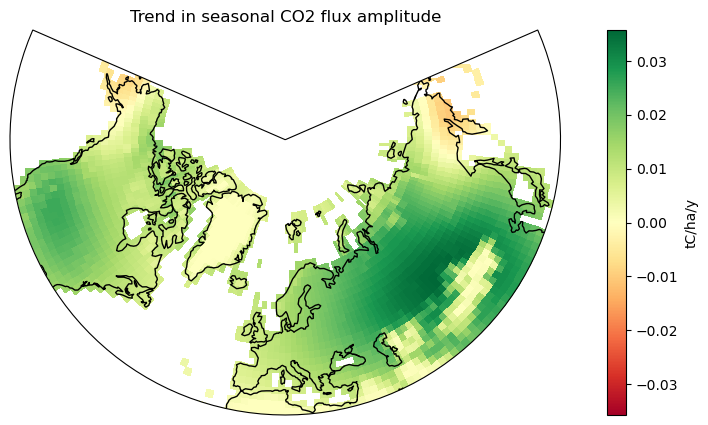

In [18]:

from matplotlib.pyplot import legend


fig = plt.figure(figsize=[12,5])
ax = fig.add_subplot(
    111,
    projection = ccrs.LambertConformal(  # projection=ccrs.Orthographic(0, 90)
        central_longitude=10.0,
        central_latitude=39.0,
        false_easting=0.0,
        false_northing=0.0,
        standard_parallels=(33, 45),
        globe=None, cutoff=30),
    facecolor="white"
)

p = fluxamp_trends.slope.plot(
    ax = ax,
    transform=ccrs.PlateCarree(),
    cmap='RdYlGn',
    add_colorbar=False
)
ax.set_global()
ax.coastlines()
ax.set_title(fluxamp_trends.slope.attrs['long_name'])
plt.colorbar(p, label=fluxamp_trends.slope.attrs['units'])
plt.show()

In [21]:
# Saving the amp and amp-trend results to disk

file_out_trend = '../data/co2invSeasAmpTrend.nc'
file_out_amp = '../data/co2invSeasAmp.nc'
co2InvTD.to_netcdf(file_out_amp)
fluxamp_trends.to_netcdf(file_out_trend)